# Fine-tuning Naver Movie Review Sentiment Classification with KoBERT
---

In this tutorial, we focus on fine-tuning with the pre-trained BERT model to classify Naver movie review sentiment.

Currently, the original author's KoBERT(Bi-directional Encoder Representations from Transformers) fine-tuning code does not work properly with the latest GluonNLP version. So we modified the code for Hands-on Lab by referring to the GluonNLP tutorial (See https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html).

Specifically, we will:

1. Load the pre-trained KoBERT model ahd attach an additional layer for classification
2. Pre-processing data for Naver Movie Sentiment Classification
3. Fine-tuning the KoBERT


<br>

## Optional: Background
---
BERT consists of 12 transformer layers for base model(110M parameters) and 24 transformer layers for large model(340M parameters).


### Input Representation

The following figure shows the input representation in BERT: 

![bert-embed](./imgs/bert-embed.png)

- ***Token Embedding***: Word embedding as a token meaning expression.
- ***Segment Embedding*** For the purpose of connecting sentence-sentence (divided by Token A and Token B), different values are assigned depending on the token type and the type of input sentence.
- ***Position Embedding***: The purpose is to give the token sequential meaning. Unlike Positional Encoding, which has a fixed value parameter for position, Positional Embedding changes position information through training.


### Special Tokens

- `[SEP]`: An identifier token that indicates the end of a sentence and is also used to distinguish two sentences. (e.g. `[SEP]` after token A, `[SEP]` after token B). Note that this token is still required while having only single-sentence

- `[CLS]`: The first token is always `[CLS]` (class token) and is used to solve the `IsNext / NotNext` classification problem for pre-training. It is used for classification task in fine-tuning.


### Byte-pair Encoding(BPE)

The more vocabulary you have, the more computational complexity. If the number of vocabularies is limited, however,  there are many unregistered words, which inevitably degrades the language representation. (i,e. Out of Vocabulary; OOV) The way to solve this is word segmentation by separating existing words.

Byte-pair Encoding(BPE) uses a bottom-up approach that gradually creates a vocabulary in units of characters. First, the words in the training data are made up of vocabulary in all letters or unicode units, and the most common unigrams are combined into a single unigram.

Let us give you a simple example. If you count the frequency of each word from some training data and save it as a dictionary (key: word, value: frequency), the result is as follows.

- `low : 5, lower : 2, newest : 6, widest : 3`

If all words of a dictionary are separated into letters (chracter), the result is as follows.
- `l o w : 5,  l o w e r : 2,  n e w e s t : 6,  w i d e s t : 3`
- `vocab: l, o, w, e, r, n, w, s, t, i, d`

1st iteration: Since the pair of unigrams with the highest frequency is `(e, s)`, we merge them into `es`.
- `l o w : 5, l o w e r : 2, n e w es t : 6, w i d es t : 3`
- `vocab: l, o, w, e, r, n, w, s, t, i, d, es`

2nd iteration: Since the pair of unigrams with the highest frequency is `(es, t)`, we merge them into `est`.
- `l o w : 5, l o w e r : 2, n e w est : 6, w i d est : 3`
- `vocab: l, o, w, e, r, n, w, s, t, i, d, es, est`

After a few iteration, we get:
- `low : 5, low e r : 2, newest : 6, widest : 3`
- `vocab: l, o, w, e, r, n, w, s, t, i, d, es, est, lo, low, ne, new, newest, wi, wid, widest`

If the word `'lowest'` appeared during the test phase, it would have been a word for OOV, but in the above set of words using the BPE algorithm, `'lowest'` is no longer OOV. The machine first divides the `'lowest'` into letters. That is, `'l, o, w, e, s, t'`. And the machine finds `'low'` and `'est'` with reference to the above word set. That is, the machine encodes 'lowest' as two words `'low'` and `'est'`.


### GELU(Gaussian Error Linear Units) Activation Function

- Combined ReLU + Dropout; Stochastically multiply the input by 0 or 1 and apply the activation function.
- It transmits a slight gradient even for negative values.

$$
\text{GELU}(x)=x\Phi(x)=0.5x\left(1+\text{erf}\left(\frac{x}{\sqrt{2}}\right)\right)\simeq 0.5x\left(1+\text{tanh}\left(\sqrt{\frac{2}{\pi}}(x+0.044715x^3)\right)\right), \\\text{ where } \Phi(x) \text{ is the cumulative distribution function of } \mathcal{N}(0, 1)
$$

<br>

## 1. Load Pre-trained Model
---

### Install/Update Packages

In [1]:
import sys, subprocess
subprocess.call([sys.executable, '-m', 'pip', 'install', 'gluonnlp', 'torch', 'sentencepiece', 'tqdm', 
                 'onnxruntime', 'transformers', 'git+https://git@github.com/SKTBrain/KoBERT.git@master'])

0

In [2]:
import io, os
import random
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet.gluon import nn, rnn
from mxnet import nd, gluon, autograd
import gluonnlp as nlp
import time
import itertools
import random
import sys

sys.path.append(os.path.join(os.getcwd(), 'src'))

from model import get_mxnet_kobert_model
from kobert.utils import get_tokenizer
from bert import BERTDatasetTransform, BERTDataset, BERTClassifier

import warnings
warnings.filterwarnings('ignore')

I assume you have at least one GPU. Of course, GPU is not required when deploying a trained model, but it is very slow without a GPU for training.

In [3]:
num_gpus = mx.context.num_gpus()
#num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

### Get pre-trained KoBERT model

In [4]:
bert_base, vocab = get_mxnet_kobert_model(use_decoder=False, use_classifier=False, ctx=ctx)

using cached model
using cached model


### Initialize BERT Classifier
We only need one addiational `Dense` layer for classification task.
GluonNLP's `model` class supports the `BERTClassifier()`, so you can easily add the classifier layer in one line. Of course, you can implement your own class. See `src/bert.py` for details.

In [5]:
bert_classifier = nlp.model.BERTClassifier(bert_base, num_classes=2, dropout=0.5)
#bert_classifier = BERTClassifier(bert_base, num_classes=2, dropout=0.5)

# Only need to initialize the classifier layer.
bert_classifier.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
bert_classifier.hybridize(static_alloc=True)

# softmax cross entropy loss for classification
loss_function = gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

metric = mx.metric.Accuracy()

In [6]:
print(bert_classifier)

BERTClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): DotProductSelfAttentionCell(
            (dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): PositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
          )
          (layer_norm): LayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (1): BERTEncoderCell(
          (dropout_layer): Dropout

<br>

## 2. Preparing the Dataset
---

Naver Movie Review data is publicly available at https://github.com/e9t/nsmc/ and consists of 150,000 training data and 50,000 test data. This data is often used for NLP benchmarking like IMDB review data in Korea. Sample data is shown below.

![naver-movieembed](./imgs/naver-movie-sample.png)

In [7]:
!wget -O train.txt https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
!wget -O test.txt https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1

--2020-05-20 11:28:24--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2020-05-20 11:28:25--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccccc63e56e2e1470aa07e29329.dl.dropboxusercontent.com/cd/0/get/A4FTSoL6Pm25UKnNATp7zS3PpxLNvYZvOOxW9vhIIwWP-PCrBLbYRVs0qr-FThhjP5xlBLgJW0i6O5Ecwx7UtveBCqyyNzcU_VuOrYC0DqJUtJDizKATLYJ_ZQzYDSQlHfw/file?dl=1# [following]
--2020-05-20 11:28:25--  https://uccccc63e56e2e1470aa07e29329.dl.dropboxusercontent.com/cd/0/get/A4FTSoL6Pm25UKnNATp7zS3PpxLNvYZvOOxW9vhIIwWP-PCrBLbYRVs0qr-FThhjP5xlBLgJW0i6O5Ecwx7UtveBCqyyNzcU_

In [8]:
dataset_train = nlp.data.TSVDataset("train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("test.txt", field_indices=[1,2], num_discard_samples=1)

<br>

## 3. Tokenization & Transform
---
Transform the dataset into the format that BERT can be trained on. 

### Get tokenizer

In [9]:
tokenizer = get_tokenizer()
bert_tokenizer = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


### Transformation

Input sentences must be converted to token index, token type, and valid length, which are necessary input vectors for BERT training. Token index is required to generate Token Embedding, token type is required for Sentence Embedding, and valid length is required to perform various operations internally. 

- ***Token Index***: The vocabulary index of each token is extracted and generated as a vector of a fixed length. We often refer to these vectors as `token_id`.
For reference, some vocabulary indexes are already reserved (e.g., The vocabulary indexes of `[PAD], [CLS], [SEP], [MASK]` are 1, 2, 3, 4, respectively).
- ***Token Type***: Since single sentence or two sentences can come in, token segment vectors are required to distinguish them if a token belongs to first sentence or the second sentence. We often refer to these vectors as `segment_id`. 
    - In the case of single sentence, the value of each token is always 0.
    - In the case of two sentences, the token belonging to the first sentence is 0, and the token belonging to the second sentence is 1.


In [10]:
print('vocabulary used for tokenization = \n%s'%vocab)
print('%s token id = %s'%(vocab.padding_token, vocab[vocab.padding_token]))
print('%s token id = %s'%(vocab.cls_token, vocab[vocab.cls_token]))
print('%s token id = %s'%(vocab.sep_token, vocab[vocab.sep_token]))
print('%s token id = %s'%(vocab.mask_token, vocab[vocab.mask_token]))

vocabulary used for tokenization = 
Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
[MASK] token id = 4


Transformation is performed through the following procedures.

- Tokenize the input sequences 
- Insert `[CLS]` token at the beginning 
- Insert `[SEP]` token between sentence A and sentence B, and at the end 
- Generate segment ids to indicate whether a token belongs to the first sequence or the second sequence. If the input sentence is not a pair, this value is always 0.
- Generate valid length.

Let's transform one sentence for test purpose.

In [11]:
def print_sample_transform(dataset, idx, bert_tokenizer, max_seq_length=20, pair=False):
    sen = [[dataset[idx][0]]]
    label = dataset[idx][1]
    data_sample = gluon.data.SimpleDataset(sen)
    transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_seq_length, pair=pair)
    out = list(data_sample.transform(transform))
    print('=== Original === ')
    print(sen)
    print('label: ' + label)
    print('\n=== Transformed ===')
    print(out)
        
print_sample_transform(dataset_train, 0, bert_tokenizer)

=== Original === 
[['아 더빙.. 진짜 짜증나네요 목소리']]
label: 0

=== Transformed ===
[(array([   2, 3093, 1698, 6456,  517,   54,  517,   54, 4368, 4396, 7316,
       5655, 5703, 2073,    3,    1,    1,    1,    1,    1], dtype=int32), array(15, dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32))]


Let's convert all sententces. When converting multiple sentences, it is convenient to use the `BERTDatasetTransform()` function, which is published in the GluonNLP tutorial. The training and evaluation time varies depending on the `max_len` parameter. In this example, we recommend 64.

In [12]:
max_len = 64
all_labels = ['0','1']

# for single sentence classification, set pair=False
# for regression task, set class_labels=None
# for inference without label available, set has_label=False
transform = BERTDatasetTransform(bert_tokenizer, max_len,
                                                class_labels=all_labels,
                                                has_label=True,
                                                pad=True,
                                                pair=False)
data_train = dataset_train.transform(transform)
data_test = dataset_test.transform(transform)

Let's check sample outputs.

In [13]:
sample_id = 0
print('token ids = \n%s'%data_train[sample_id][0])
print('segment ids = \n%s'%data_train[sample_id][1])
print('valid length = \n%s'%data_train[sample_id][2])
print('label = \n%s'%data_train[sample_id][3])

token ids = 
[   2 3093 1698 6456  517   54  517   54 4368 4396 7316 5655 5703 2073
    3    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
segment ids = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
valid length = 
15
label = 
[0]


<br>

## 4. Creating DataLoader and Trainer 
---
We need to create an iterator for tha dataset using `DataLoader`. Iterators save memory during training because you don not have to load the entire dataset into memory.

### Setting hyperparameters

In [14]:
batch_size = 64 * num_gpus
num_epochs = 4
max_grad_norm = 1
log_interval = 50
lr = 5e-5

`FixedBucketSampler()` assigns each data sample to a fixed bucket based on its length.
Without the bucketing strategy, it is inefficient because one or two long sentences in each bucket can cause unnecessary padding.

![no_bucket_strategy](./imgs/no_bucket_strategy.png)


![fixed_bucket_strategy_ratio0.7](./imgs/fixed_bucket_strategy_ratio0.7.png)

In [15]:
%%time
# The FixedBucketSampler and the DataLoader for making the mini-batches
train_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_train],
                                            batch_size=batch_size,
                                            shuffle=True)
train_dataloader = gluon.data.DataLoader(data_train, batch_sampler=train_sampler)

CPU times: user 22.8 s, sys: 0 ns, total: 22.8 s
Wall time: 22.8 s


In [16]:
%%time
test_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_test],
                                            batch_size=batch_size,
                                            shuffle=True)
test_dataloader = mx.gluon.data.DataLoader(data_test, batch_sampler=test_sampler)

CPU times: user 7.57 s, sys: 0 ns, total: 7.57 s
Wall time: 7.57 s


Initialize the `gluon.Trainer()`. Gradient clipping to prevent the exploding gradient can be implemented during training, but can be used simply by specifying it when initializing the `gluon.Trainer()`.

In [17]:
all_model_params = bert_classifier.collect_params()
trainer = gluon.Trainer(all_model_params, 'adam',
                        {'learning_rate': lr, 'epsilon': 1e-9, 'clip_gradient': 1}, 
                        kvstore='device')
    
# Weight Decay is not applied to LayerNorm and Bias.
for _, v in bert_classifier.collect_params('.*beta|.*gamma|.*bias').items():
    v.wd_mult = 0.0
    
# Collect all differentiable parameters
# `grad_req == 'null'` indicates no gradients are calculated (e.g. constant parameters)
# The gradients for these params are clipped later
params = [p for p in all_model_params.values() if p.grad_req != 'null']  

<br>

## 5. Fine-tuning the model
---
Now you can start fine-tuning the model with a few epochs. The code below is based on the [GluonNLP tutorial](https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html) and the [BERT Fine-tuning](https://mccormickml.com/2019/07/22/BERT-fine-tuning/). However, since both tutorials do not support multi-GPUs, the code has been slightly modified to enable multi-GPU training. <br>
Training takes about 21 minutes to run on a `p3.8xlarge` instance.

In [18]:
import time
import datetime
import tqdm
from tqdm.notebook import tqdm

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def evaluate_accuracy(model, data_iter, ctx):
    acc = mx.metric.Accuracy()
    total_loss = 0
    
    for batch_id, (token_ids, segment_ids, valid_length, label) in enumerate(tqdm(data_iter)):
        
        # Load the data to the GPUs
        token_ids_ = gluon.utils.split_and_load(token_ids, ctx, even_split=False)
        valid_length_ = gluon.utils.split_and_load(valid_length, ctx, even_split=False)
        segment_ids_ = gluon.utils.split_and_load(segment_ids, ctx, even_split=False)
        label_ = gluon.utils.split_and_load(label, ctx, even_split=False)

        for t, v, s, l in zip(token_ids_, valid_length_, segment_ids_, label_):
            # Forward computation
            out = model(t, s, v.astype('float32'))
            ls = loss_function(out, l).mean()
            total_loss += ls.asscalar()
            acc.update(preds=out, labels=l)
        
    avg_acc = acc.get()[1]
    avg_loss = total_loss / batch_id
    
    print('Validation loss={:.4f}, acc={:.3f}'.format(avg_loss, avg_acc))

    return avg_acc, avg_loss   

In [19]:
%%time
import os
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving model to %s" % output_dir)

training_stats = []
step_num = 0

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_id in range(num_epochs):

    # === Training phase ===
    
    # Measure how long the training epoch takes.
    t0 = time.time()    
    
    metric.reset()
    step_loss = 0
    total_loss = 0
    
    for batch_id, (token_ids, segment_ids, valid_length, label) in enumerate(tqdm(train_dataloader)):
        
        # Load the data to the GPUs
        token_ids_ = gluon.utils.split_and_load(token_ids, ctx, even_split=False)
        valid_length_ = gluon.utils.split_and_load(valid_length, ctx, even_split=False)
        segment_ids_ = gluon.utils.split_and_load(segment_ids, ctx, even_split=False)
        label_ = gluon.utils.split_and_load(label, ctx, even_split=False)

        losses = []
        with autograd.record():

            for t, v, s, l in zip(token_ids_, valid_length_, segment_ids_, label_):
                # Forward computation
                out = bert_classifier(t, s, v.astype('float32'))
                ls = loss_function(out, l).mean()

                losses.append(ls)
                metric.update([l], [out])

        # Perform a backward pass to calculate the gradients        
        for ls in losses:
            ls.backward()  
        
        trainer.step(1)
#         trainer.allreduce_grads()
#         nlp.utils.clip_grad_global_norm(params, 1)
#         trainer.update(1)

        # Diff 5: sum losses over all devices
        step_loss += sum([l.sum().asscalar() for l in losses])
        total_loss += sum([l.sum().asscalar() for l in losses])    
        #metric.update([label], [out])

        # Printing vital information
        if (batch_id + 1) % (log_interval) == 0:
            print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}'
                         .format(epoch_id, batch_id + 1, len(train_dataloader),
                                 step_loss / log_interval,
                                 trainer.learning_rate, metric.get()[1]))
            step_loss = 0
            
        train_avg_acc = metric.get()[1]
        train_avg_loss = total_loss / batch_id
        total_loss = 0
    
    
    # Measure how long this epoch took.
    train_time = format_time(time.time() - t0)
    
    # === Validation phase ===
    
    # Measure how long the validation epoch takes.    
    t0 = time.time()    
    valid_avg_acc, valid_avg_loss = evaluate_accuracy(bert_classifier, test_dataloader, ctx)

    # Measure how long this epoch took.
    valid_time = format_time(time.time() - t0)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
     # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_id + 1,
            'train_acc': train_avg_acc,
            'train_loss': train_avg_loss,
            'train_time': train_time,
            'valid_acc': valid_avg_acc,
            'valid_loss': valid_avg_loss,
            'valid_time': valid_time
        }
    )    
    
    # === Save Model Parameters ===
    bert_classifier.save_parameters('{}/net_epoch{}.params'.format(output_dir, epoch_id))    

Saving model to ./model_save/


[Epoch 0 Batch 50/592] loss=2.3405, lr=0.0000500, acc=0.678
[Epoch 0 Batch 100/592] loss=1.8955, lr=0.0000500, acc=0.729
[Epoch 0 Batch 150/592] loss=1.6426, lr=0.0000500, acc=0.760
[Epoch 0 Batch 200/592] loss=1.4466, lr=0.0000500, acc=0.780
[Epoch 0 Batch 250/592] loss=1.3675, lr=0.0000500, acc=0.794
[Epoch 0 Batch 300/592] loss=1.4751, lr=0.0000500, acc=0.801
[Epoch 0 Batch 350/592] loss=1.3329, lr=0.0000500, acc=0.809
[Epoch 0 Batch 400/592] loss=1.2909, lr=0.0000500, acc=0.816
[Epoch 0 Batch 450/592] loss=1.2136, lr=0.0000500, acc=0.822
[Epoch 0 Batch 500/592] loss=1.2886, lr=0.0000500, acc=0.826
[Epoch 0 Batch 550/592] loss=1.2262, lr=0.0000500, acc=0.830




Validation loss=1.1565, acc=0.879


[Epoch 1 Batch 50/592] loss=1.0926, lr=0.0000500, acc=0.888
[Epoch 1 Batch 100/592] loss=1.0264, lr=0.0000500, acc=0.891
[Epoch 1 Batch 150/592] loss=1.1830, lr=0.0000500, acc=0.885
[Epoch 1 Batch 200/592] loss=1.0743, lr=0.0000500, acc=0.886
[Epoch 1 Batch 250/592] loss=1.0176, lr=0.0000500, acc=0.888
[Epoch 1 Batch 300/592] loss=1.0182, lr=0.0000500, acc=0.889
[Epoch 1 Batch 350/592] loss=1.0387, lr=0.0000500, acc=0.889
[Epoch 1 Batch 400/592] loss=1.0263, lr=0.0000500, acc=0.890
[Epoch 1 Batch 450/592] loss=1.0123, lr=0.0000500, acc=0.891
[Epoch 1 Batch 500/592] loss=0.9843, lr=0.0000500, acc=0.892
[Epoch 1 Batch 550/592] loss=1.0644, lr=0.0000500, acc=0.891




Validation loss=1.0665, acc=0.890


[Epoch 2 Batch 50/592] loss=0.8132, lr=0.0000500, acc=0.920
[Epoch 2 Batch 100/592] loss=0.8058, lr=0.0000500, acc=0.920
[Epoch 2 Batch 150/592] loss=0.8242, lr=0.0000500, acc=0.920
[Epoch 2 Batch 200/592] loss=0.8477, lr=0.0000500, acc=0.919
[Epoch 2 Batch 250/592] loss=0.9914, lr=0.0000500, acc=0.915
[Epoch 2 Batch 300/592] loss=0.8334, lr=0.0000500, acc=0.916
[Epoch 2 Batch 350/592] loss=0.8210, lr=0.0000500, acc=0.917
[Epoch 2 Batch 400/592] loss=0.8663, lr=0.0000500, acc=0.916
[Epoch 2 Batch 450/592] loss=0.9275, lr=0.0000500, acc=0.915
[Epoch 2 Batch 500/592] loss=0.7771, lr=0.0000500, acc=0.915
[Epoch 2 Batch 550/592] loss=0.8687, lr=0.0000500, acc=0.915




Validation loss=1.1556, acc=0.891


[Epoch 3 Batch 50/592] loss=0.6227, lr=0.0000500, acc=0.941
[Epoch 3 Batch 100/592] loss=0.6630, lr=0.0000500, acc=0.939
[Epoch 3 Batch 150/592] loss=0.7313, lr=0.0000500, acc=0.936
[Epoch 3 Batch 200/592] loss=0.6676, lr=0.0000500, acc=0.935
[Epoch 3 Batch 250/592] loss=0.6529, lr=0.0000500, acc=0.936
[Epoch 3 Batch 300/592] loss=0.6622, lr=0.0000500, acc=0.936
[Epoch 3 Batch 350/592] loss=0.6504, lr=0.0000500, acc=0.936
[Epoch 3 Batch 400/592] loss=0.6530, lr=0.0000500, acc=0.936
[Epoch 3 Batch 450/592] loss=0.7057, lr=0.0000500, acc=0.935
[Epoch 3 Batch 500/592] loss=0.7444, lr=0.0000500, acc=0.935
[Epoch 3 Batch 550/592] loss=0.6628, lr=0.0000500, acc=0.935




Validation loss=1.1965, acc=0.893
CPU times: user 35min 14s, sys: 10min 35s, total: 45min 49s
Wall time: 21min 28s


<br>

## 6. Evaluation
---

Let's take a brief look at the training results so far.
Having a lot of epochs is not a good thing. As you can see in the graph and table, training metrics continue to decrease, but validation metrics decrease after some point.

The validation accuracy is pretty good with 89~89.7%, which is slightly less than the 90.1% accuracy on the official site, but has not been hyperparameter tuned.

In [20]:
import pandas as pd
pd.set_option('precision', 4)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,train_acc,train_loss,train_time,valid_acc,valid_loss,valid_time
epoch,,,,,,
1,0.8331,0.0022,0:04:24,0.8795,1.1565,0:00:58
2,0.8910,0.0014,0:04:22,0.8897,1.0665,0:00:58
3,0.9153,0.0016,0:04:22,0.8906,1.1556,0:00:58
4,0.9346,0.0009,0:04:22,0.8934,1.1965,0:00:58


In [21]:
def plot_training_stats(df_stats, num_epochs=5):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.2)
    plt.rcParams["figure.figsize"] = (15,6)

    xticks = list(range(1, num_epochs+1))

    plt.subplot(221)

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(df_stats['train_loss'], 'b-o', label="Training")
    ax1.plot(df_stats['valid_loss'], 'g-o', label="Validation")
    ax1.set_xticks(xticks)     
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(df_stats['train_acc'], 'b-o', label="Training")
    ax2.plot(df_stats['valid_acc'], 'g-o', label="Validation")
    ax2.set_xticks(xticks) 
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()    

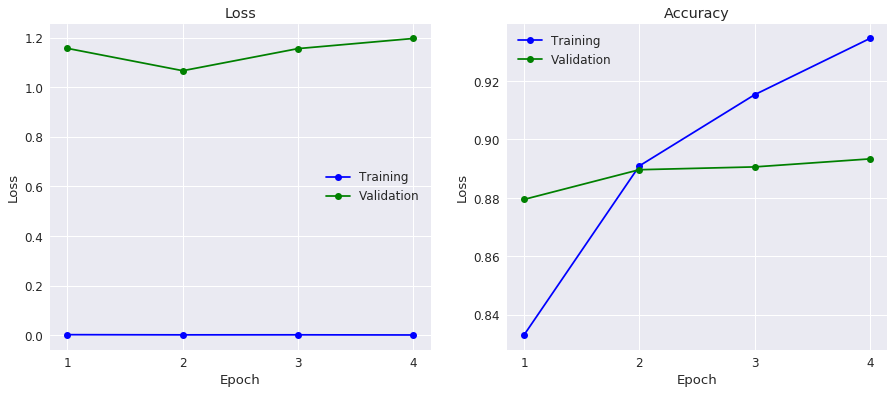

In [25]:
% matplotlib inline
plot_training_stats(df_stats, num_epochs)

Delete all but the best performing models.

In [23]:
idx = df_stats['valid_acc'].argmax() - 1
save_filename = 'net_epoch{}.params'.format(idx)

for filename in os.listdir(output_dir):
    if filename.endswith('params'):
        if filename == save_filename:
            os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, 'net_nsmc.params'))
        else:
            os.remove(os.path.join(output_dir, filename))

If you want to deploy the fine-tuned model to the SageMaker Endpoint, please copy the `.spiece` file to the model parameter folder and compress them with `model.tar.gz`.

```bash
# Example shell scripts
$ cp ~/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece ./model_save/.
$ cd model_save
$ tar cvfz model.tar.gz ./*.params ./*.spiece
$ aws s3 cp ./model.tar.gz s3://<your-bucket-name>/kobert-model/model.tar.gz
```

In [24]:
!cp ~/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece ./model_save/.
!tar cvfz ./model_save/model.tar.gz ./model_save/*.params ./model_save/*.spiece

./model_save/net_nsmc.params
./model_save/kobert_news_wiki_ko_cased-1087f8699e.spiece


## References

[1] Devlin, Jacob, et al. "Bert:
Pre-training of deep
bidirectional transformers for language understanding."
arXiv preprint
arXiv:1810.04805 (2018).

[2] Dolan, William B., and Chris
Brockett.
"Automatically constructing a corpus of sentential paraphrases."
Proceedings of
the Third International Workshop on Paraphrasing (IWP2005). 2005.

[3] Peters,
Matthew E., et al. "Deep contextualized word representations." arXiv
preprint
arXiv:1802.05365 (2018).

[4] GluonNLP Tutorial. Fine-tuning Sentence Pair Classification with BERT, <https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html>.

[5] Chris McCormick. BERT Fine-Tuning Tutorial with PyTorch, <https://mccormickml.com/2019/07/22/BERT-fine-tuning>.